In [1]:
import tensorflow as tf
import numpy as np
import pickle as pkl
from sklearn.manifold import TSNE
from flip_gradient import flip_gradient
from utils import *
from timeit import default_timer as timer
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy.misc

from PIL import Image
import os
import pandas as pd
import numpy as np


/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
root = '/Users/sharath/Documents/sharath/OneDrive - University of Essex/Datascience Assigment/officeimages'


In [2]:
## defineing the directory of data set

directoryamazon = root + "/amazon"

directorydslr = root + "/dslr"

directoryweb = root + "/webcam"

In [3]:
img_size = 200
def get_image_list(dic):
    image_list = []
    image_label = []
    for root, dirs, files in os.walk(dic):
        for file in files:
            if file.endswith('.jpg'):
                temp = str(root).split('/')
                label = temp[-1]
                im = Image.open(root + '/' + file)
                im = im.resize((img_size,img_size))
                imagedata = np.array(im)
                image_list.append(imagedata)
                image_label.append(label)

    ## returing the appended list
    return np.array(image_list), np.array(image_label)

In [4]:
## load images from the directory

## get amazon images
trainamazon, amazonlabel = get_image_list(directoryamazon)

## get dslr images
traindslr, dslrlabel = get_image_list(directorydslr)

## get webcam images
trainweb, weblabel = get_image_list(directoryweb)


In [5]:
print trainamazon.shape
print set(amazonlabel)

(2817, 200, 200, 3)
set(['calculator', 'ring_binder', 'printer', 'keyboard', 'scissors', 'laptop_computer', 'mouse', 'monitor', 'mug', 'tape_dispenser', 'pen', 'bike', 'speaker', 'back_pack', 'desktop_computer', 'punchers', 'mobile_phone', 'paper_notebook', 'ruler', 'letter_tray', 'file_cabinet', 'phone', 'bookcase', 'projector', 'stapler', 'trash_can', 'bike_helmet', 'headphones', 'desk_lamp', 'desk_chair', 'bottle'])


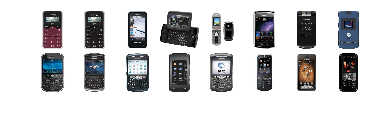

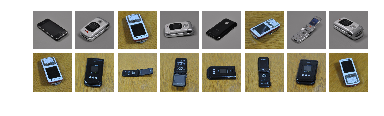

In [6]:
imshow_grid(trainamazon)
imshow_grid(traindslr)

In [7]:
# input image dimensions
img_rows, img_cols = img_size, img_size
num_classes = 31
input_shape = (img_rows, img_cols, 3)

In [8]:
N_AT = trainamazon.astype('float32')
N_AT /= 255

N_DT = traindslr.astype('float32')
N_DT /= 255

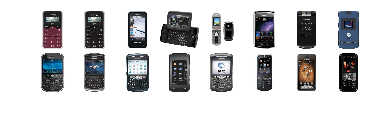

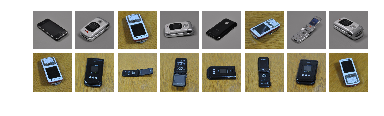

In [9]:
imshow_grid(N_AT)
imshow_grid(N_DT)

In [51]:
source = trainamazon
s_l = amazonlabel

target = traindslr
t_l = dslrlabel

In [52]:

sf = (len(source))
ss = int((len(source))*.20)
sm = int(sf*0.50)+ss
# se = sf - sm

tf = (len(target))
ts = int((len(target))*.20)
tm = int(tf*0.50)+ss
# te = tf - tm


In [53]:


x_test,y_test = source[:ss] , s_l[:ss]
x_train, y_train = source[ss:sm] , s_l[ss:sm]
x_valid, y_valid = source[sm:], s_l[sm:]

Mx_test,My_test = target[:ts] , t_l[:ts]
Mx_train, My_train = target[ts:tm] , t_l[ts:tm]
Mx_valid, My_valid = target[tm:] , t_l[tm:]



In [11]:
model = Sequential()
model.add(Conv2D(64,kernel_size=(8,8),activation='relu',input_shape=input_shape, strides=(4,4)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add((Conv2D(32,kernel_size=(4, 4), activation='relu', strides=(4,4))))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.compile(loss='mse',optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 64)        12352     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          32800     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               36992     
Total para

In [12]:
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [13]:
target=[(Mx_train, y_train),(Mx_valid, My_valid)]
source=[(x_train, y_train),(x_valid, y_valid)]

In [14]:
SX=np.asarray(source[0][0])
SY=np.asarray(source[0][1])
SVX=np.asarray(source[1][0])
SVY=np.asarray(source[1][1])
input_shape=SX.shape[1:]

TX = np.asarray(target[0][0])
TY = np.asarray(target[0][1])
TVX = np.asarray(target[1][0])
TVY = np.asarray(target[1][1])

MX=np.concatenate((SX, TX), axis=0)
MY=np.concatenate((np.zeros(SX.shape[0]), np.ones(TX.shape[0])),axis=0)

MVX = np.concatenate((SVX, TVX),axis=0)
MVY = np.concatenate((np.zeros(SVX.shape[0]), np.ones(TVX.shape[0])),axis=0)

input_shape=SX.shape[1:]

In [15]:
def Train_classifier(x,y):
    x_features=model.predict(x)
    clf=RandomForestClassifier(n_estimators=18)
    clf=clf.fit(x_features, y)
    return clf

def Predict_from_clf(clf,x):
    x_features=model.predict(x)
    y=clf.predict(x_features)
    return y

def saveModel(filename):
    file=open(filename+'.json','w')
    file.write(model.to_json())
    model.save_weights(filename+'.h5')
    file.close()

def load_model(filename):
    file=open(filename+'.json')
    model=file.read()
    model=model_from_json(model)
    model.load_weight(filename+'.json')

def new_score_fun(label_accuracy,domain_accuray):
    return label_accuracy - (4*(np.square(domain_accuray-0.5)))


In [16]:
label_clf = RandomForestClassifier()
domain_clf = RandomForestClassifier()

In [17]:
RD_Indices = np.random.choice(a=list(range(MX.shape[0])),size=100)
M_D_TX = MX[RD_Indices]
M_D_TY = MY[RD_Indices]

RS_Indices = np.random.choice(a=list(range(SX.shape[0])),size=100)
S_TX = SX[RS_Indices]
S_TY = SY[RS_Indices]

RDV_indices = np.random.choice(a=list(range(MVX.shape[0])), size=100)
M_D_VX = MVX[RDV_indices]
M_D_VY = MVY[RDV_indices]

SV_indices = np.random.choice(a=list((range(SVX.shape[0]))),size=100)
validX = SVX[SV_indices]
validY = SVY[SV_indices]

In [18]:
label_clf = Train_classifier(SX,SY)
label_pred = Predict_from_clf(label_clf, validX)
label_accuracy = accuracy_score(validY,label_pred)
print ('label_accuracy',label_accuracy )

domain_clf = Train_classifier(M_D_TX, M_D_TY)
domain_pred = Predict_from_clf(domain_clf, M_D_VX)
domain_accuracy = accuracy_score(M_D_VY, domain_pred)
print ('domain_accuracy',domain_accuracy )

# print('Baseline label-clf accuracy: %0.3f, baseline domain_clf: %0.3f' %(label_accuracy, domain_accuracy))
weight_modifier=NNWeightHelper(model)
weights=weight_modifier.get_weights()
print('total weights to evolve:',len(weights) )



('label_accuracy', 0.01)
('domain_accuracy', 1.0)
('total weights to evolve:', 82144)


In [19]:
snes=SNES(weights,1,10)

In [20]:
logscore = []
for i in range(5):
    start = timer()
    new_weights=snes.ask()

    complied_score = []
    domain_accuracys = []
    label_accuracys = []

    for w in new_weights:
        weight_modifier.set_weights(w)

        label_clf=Train_classifier(S_TX,S_TY)
        label_predictions = Predict_from_clf(label_clf, validX)
        label_accuracy=accuracy_score(validY,label_predictions)
#         print ('label_accuracy',label_accuracy )

        domain_clf = Train_classifier(M_D_TX,M_D_TY)
        domain_predictions=Predict_from_clf(domain_clf,M_D_VX)
        domain_accuracy=accuracy_score(M_D_VY,domain_predictions)
#         print ('domain_accuracy',domain_accuracy )


        new_score = new_score_fun(label_accuracy, domain_accuracy)
        complied_score.append(new_score)
        domain_accuracys.append(domain_accuracy)
        label_accuracys.append(label_accuracy)

    snes.tell(new_weights,complied_score)
    max_index=np.argmax(complied_score)
    end = timer()
    print("It took", end - start, "seconds to complete generation")
    print("the fit model has label_accuracy: %0.3f and domain_accuracy:%0.3f and complied_score:%0.3f" 
          %(label_accuracys[max_index], domain_accuracys[max_index], complied_score[max_index]))
    
    logscore.append([complied_score[max_index],label_accuracys[max_index],domain_accuracys[max_index]])


('Step', 1, ':', -0.8363999999999998, 'best:', -0.8363999999999998, 10)
('It took', 10.577416896820068, 'seconds to complete generation')
the fit model has label_accuracy: 0.010 and domain_accuracy:0.960 and complied_score:-0.836
('Step', 2, ':', -0.8463999999999998, 'best:', -0.8363999999999998, 10)
('It took', 9.946094036102295, 'seconds to complete generation')
the fit model has label_accuracy: 0.000 and domain_accuracy:0.960 and complied_score:-0.846
('Step', 3, ':', -0.7743999999999999, 'best:', -0.7743999999999999, 10)
('It took', 9.844259023666382, 'seconds to complete generation')
the fit model has label_accuracy: 0.000 and domain_accuracy:0.940 and complied_score:-0.774
('Step', 4, ':', -0.8535999999999999, 'best:', -0.7743999999999999, 10)
('It took', 11.116370916366577, 'seconds to complete generation')
the fit model has label_accuracy: 0.030 and domain_accuracy:0.970 and complied_score:-0.854
('Step', 5, ':', -0.8815999999999999, 'best:', -0.7743999999999999, 10)
('It took'

In [21]:
weight_modifier.set_weights(snes.center)

In [22]:
saveModel('mnistmodeltest_dense128_new')
import pandas as pd
scorelog = pd.DataFrame(logscore)
scorelog.to_csv('logscore1.csv', header=None)

In [54]:
label_clf = Train_classifier(trainamazon,amazonlabel)
sourcePredictions = Predict_from_clf(label_clf, x_test)
sourceAccuray = accuracy_score(y_test,sourcePredictions)
print  "label predicitions on source %0.3f" % (sourceAccuray)

targetPredictions = Predict_from_clf(label_clf, Mx_test)
targetAccuracy = accuracy_score(targetPredictions, My_test)
print "label predicitons on target %0.3f" %(targetAccuracy)

label predicitions on MNIST 1.000
label predicitons on MNISTM 0.051


In [55]:
R_MT_INDEX = np.random.choice(a=list(range(MX.shape[0])), size=MY.shape[0])
TM_X = MX[R_MT_INDEX]
TM_Y = MY[R_MT_INDEX]

TEST_MX = np.concatenate([x_test, Mx_test], axis=0)
TEST_MY = np.concatenate([np.zeros(x_test.shape[0]), np.ones(Mx_test.shape[0])], axis=0)

In [56]:
domain_clf = Train_classifier(TM_X, TM_Y)
domain_pred = Predict_from_clf(domain_clf, TEST_MX)
domain_accuracy= accuracy_score(TEST_MY, domain_pred)
print("domain predicitions accuracy: %0.3f" %(domain_accuracy))

domain predicitions accuracy: 0.994


In [59]:
log = pd.read_csv('logscore1.csv', header=None)
print log

   0       1
0  0 -0.8364
1  1 -0.8464
2  2 -0.7744
3  3 -0.8536
4  4 -0.8816


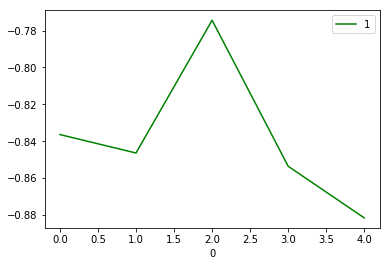

In [60]:
log.plot(x=0, y=1, style='g')
log.plot(x=0, y=2, style='g')
log.plot(x=0, y=3, style='g')
